In [1]:
!pip install missingno MissForest lightgbm tqdm statsmodels lazypredict category_encoders shap



Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import missingno as msno
from sklearn.model_selection import train_test_split
from missforest import MissForest
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
import shap
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from lazypredict.Supervised import LazyRegressor
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import TargetEncoder
from sklearn import linear_model
from sklearn.linear_model import Lasso
from statsmodels.tools.tools import add_constant

In [3]:
df = pd.read_csv('/workspaces/anagabsr-intro-ml/data/raw/internal-link.csv')
df.set_index('id', inplace=True)
pd.set_option('display.max_columns', None)
df.head()


,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,,,
2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.65,-73.97,Private room,149,1,9,2018-10-19,0.21,6,365
2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75,-73.98,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.81,-73.94,Private room,150,3,0,NaN,NaN,1,365
3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.69,-73.96,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.80,-73.94,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
df.shape

(48895, 15)

In [5]:
unicos = df.nunique()
print(unicos)

name                              47905
host_id                           37457
host_name                         11452
neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
last_review                        1764
reviews_per_month                   937
calculated_host_listings_count       47
availability_365                    366
dtype: int64


In [6]:
#Identificar columnas con valores constantes 

df[unicos[unicos==1].index]

#No hay columnas con valores constantes unicos(visto arriba)

""
id
2539
2595
3647
3831
5022
...
36484665
36485057
36485431


In [7]:
#identificar filas duplicadas
df.duplicated().sum()

np.int64(0)

In [8]:
#identificar columnas duplicadas

df.T.duplicated().sum()
df.T.duplicated(keep=False)

name                              False
host_id                           False
host_name                         False
neighbourhood_group               False
neighbourhood                     False
latitude                          False
longitude                         False
room_type                         False
price                             False
minimum_nights                    False
number_of_reviews                 False
last_review                       False
reviews_per_month                 False
calculated_host_listings_count    False
availability_365                  False
dtype: bool

In [9]:
#Identificar y eliminar columnas redundantes

df.drop(['name','host_name'],axis=1,inplace=True)


In [10]:
df.shape

(48895, 13)

Valores faltantes 

In [11]:
faltantes = df.isna().mean()*100
faltantes[faltantes>0]

last_review         20.56
reviews_per_month   20.56
dtype: float64

In [ ]:

#df['name'].isna().sum()
#df[df['reviews_per_month'].isna()==True] 

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,
3647,4632,Manhattan,Harlem,40.81,-73.94,Private room,150,3,0,NaN,NaN,1,365
7750,17985,Manhattan,East Harlem,40.80,-73.95,Entire home/apt,190,7,0,NaN,NaN,2,249
8700,26394,Manhattan,Inwood,40.87,-73.93,Private room,80,4,0,NaN,NaN,1,0
11452,7355,Brooklyn,Bedford-Stuyvesant,40.69,-73.94,Private room,35,60,0,NaN,NaN,1,365
11943,45445,Brooklyn,Flatbush,40.64,-73.96,Private room,150,1,0,NaN,NaN,1,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36484665,8232441,Brooklyn,Bedford-Stuyvesant,40.68,-73.95,Private room,70,2,0,NaN,NaN,2,9
36485057,6570630,Brooklyn,Bushwick,40.70,-73.93,Private room,40,4,0,NaN,NaN,2,36
36485431,23492952,Manhattan,Harlem,40.81,-73.95,Entire home/apt,115,10,0,NaN,NaN,1,27


Visualizar valores faltantes como matriz 

<Axes: >

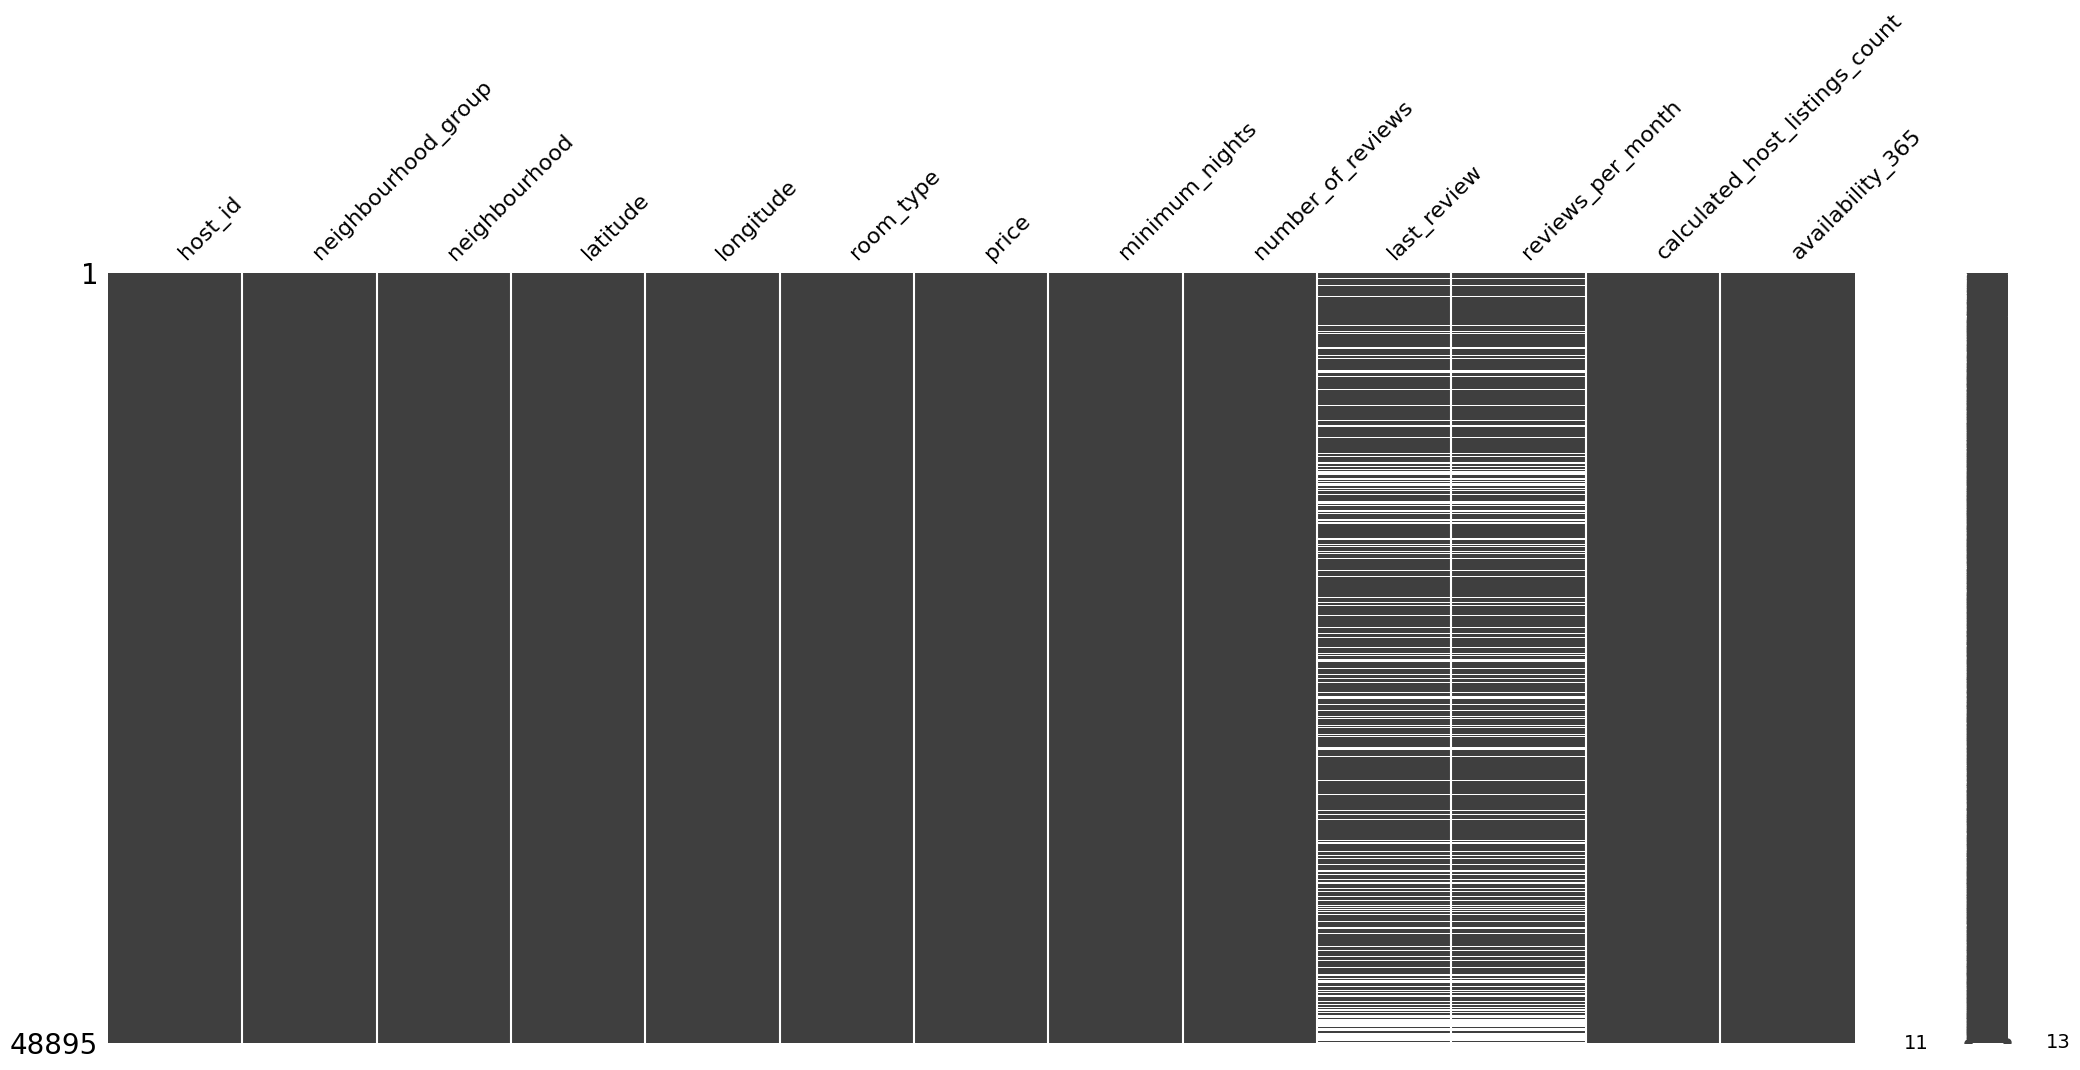

In [13]:
msno.matrix(df)

Convertir valores NaN de columna "Reviews per month" a 0

In [14]:
df['reviews_per_month'].fillna(0,inplace=True)
pd.set_option('display.max_columns', None)
df.head()

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,
2539,2787,Brooklyn,Kensington,40.65,-73.97,Private room,149,1,9,2018-10-19,0.21,6,365
2595,2845,Manhattan,Midtown,40.75,-73.98,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3647,4632,Manhattan,Harlem,40.81,-73.94,Private room,150,3,0,NaN,0.00,1,365
3831,4869,Brooklyn,Clinton Hill,40.69,-73.96,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
5022,7192,Manhattan,East Harlem,40.80,-73.94,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Crear y calcular columna "days since last review"

In [15]:
df['last_review'] = pd.to_datetime(df['last_review'])

cutoff_date = df['last_review'].max()

df['days_since_lastreview'] = (cutoff_date - df['last_review']).dt.days
pd.set_option('display.max_columns', None)
df.iloc()

Imputar valor extremo a NaN "days since last review"

In [16]:
df['days_since_lastreview'].fillna(-1,inplace=True)
pd.set_option('display.max_columns',None)
df.head()

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,days_since_lastreview
id,,,,,,,,,,,,,,
2539,2787,Brooklyn,Kensington,40.65,-73.97,Private room,149,1,9,2018-10-19,0.21,6,365,262.00
2595,2845,Manhattan,Midtown,40.75,-73.98,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,48.00
3647,4632,Manhattan,Harlem,40.81,-73.94,Private room,150,3,0,NaT,0.00,1,365,-1.00
3831,4869,Brooklyn,Clinton Hill,40.69,-73.96,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,3.00
5022,7192,Manhattan,East Harlem,40.80,-73.94,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,231.00


Eliminar columna redundante "last_review"

In [17]:
df.drop(['last_review'],axis=1,inplace=True)
pd.set_option('display.max_columns',None)
df.head()

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,days_since_lastreview
id,,,,,,,,,,,,,
2539,2787,Brooklyn,Kensington,40.65,-73.97,Private room,149,1,9,0.21,6,365,262.00
2595,2845,Manhattan,Midtown,40.75,-73.98,Entire home/apt,225,1,45,0.38,2,355,48.00
3647,4632,Manhattan,Harlem,40.81,-73.94,Private room,150,3,0,0.00,1,365,-1.00
3831,4869,Brooklyn,Clinton Hill,40.69,-73.96,Entire home/apt,89,1,270,4.64,1,194,3.00
5022,7192,Manhattan,East Harlem,40.80,-73.94,Entire home/apt,80,10,9,0.10,1,0,231.00


Train Test Split

In [18]:
df_raw = df.copy()

In [19]:
df = df.drop(columns=['host_id'])

In [20]:
X = df.drop('price',axis=1)
y = df['price']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
counts = df['room_type'].value_counts()
print(counts)

room_type
Entire home/apt    25409
Private room       22326
Shared room         1160
Name: count, dtype: int64


In [23]:
cols = ['neighbourhood_group']
counts = df['neighbourhood_group'].value_counts()
print(counts)

neighbourhood_group
Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: count, dtype: int64


Codificación de variables categóricas
Ordinal encoder: para variable Room type


In [24]:
room_type_order = [['Shared room','Private room','Entire home/apt']]

ordinal_encoder = OrdinalEncoder(categories=room_type_order,handle_unknown='use_encoded_value',unknown_value=-1)

X_train['room_type_encoded'] = ordinal_encoder.fit_transform(X_train[['room_type']])
X_test['room_type_encoded']= ordinal_encoder.transform(X_test[['room_type']])

X_train.drop('room_type',axis=1,inplace=True)
X_test.drop('room_type',axis=1,inplace=True)





Codificación de variables categóricas con TargetEncoder: neighbourhood_group & neighbourhood

In [25]:
cols = ['neighbourhood_group','neighbourhood']


for column in cols:
        target_encoder = TargetEncoder(target_type='continuous',smooth='auto',cv=5)

        X_train_col_enc = target_encoder.fit_transform(X_train[[column]],y_train)
        X_test_col_enc = target_encoder.transform(X_test[[column]])
        X_train[f'{column}_encoded'] = X_train_col_enc 
        X_test[f'{column}_encoded'] = X_test_col_enc 
        X_train.drop(column,axis=1,inplace=True)
        X_test.drop(column,axis=1,inplace=True)



In [26]:
X_train.head()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,days_since_lastreview,room_type_encoded,neighbourhood_group_encoded,neighbourhood_encoded
id,,,,,,,,,,,
25674366,40.72,-73.96,3,11,0.87,1,1,53.00,2.00,125.11,144.36
19100971,40.85,-73.94,2,2,0.16,1,0,378.00,1.00,197.09,91.93
24209867,40.69,-73.96,2,0,0.00,2,0,-1.00,1.00,124.32,108.69
22451798,40.68,-73.93,3,87,4.91,1,267,3.00,2.00,125.75,106.82
5344850,40.75,-73.90,5,13,0.25,1,0,202.00,1.00,100.56,90.89


Outliers

In [27]:
X_train.describe().T



,count,mean,std,min,25%,50%,75%,max
latitude,39116.00,40.73,0.05,40.50,40.69,40.72,40.76,40.91
longitude,39116.00,-73.95,0.05,-74.24,-73.98,-73.96,-73.94,-73.71
minimum_nights,39116.00,7.14,21.47,1.00,1.00,3.00,5.00,1250.00
number_of_reviews,39116.00,23.33,44.50,0.00,1.00,5.00,24.00,629.00
reviews_per_month,39116.00,1.09,1.60,0.00,0.04,0.37,1.59,58.50
calculated_host_listings_count,39116.00,7.19,33.17,1.00,1.00,1.00,2.00,327.00
availability_365,39116.00,113.45,131.85,0.00,0.00,46.00,229.00,365.00
days_since_lastreview,39116.00,218.07,384.83,-1.00,4.00,24.00,240.00,2996.00
room_type_encoded,39116.00,1.50,0.54,0.00,1.00,2.00,2.00,2.00
neighbourhood_group_encoded,39116.00,153.75,41.06,85.32,124.32,125.75,198.88,200.46


In [28]:
iso = IsolationForest(random_state=123)
df_train_outliers = X_train.copy()
df_train_outliers['outlier_flag'] = iso.fit_predict(X_train)


In [29]:
df_train_outliers['outlier_flag'].value_counts()

outlier_flag
 1    34922
-1     4194
Name: count, dtype: int64

In [30]:
X_train.select_dtypes('number').columns


Index(['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'days_since_lastreview', 'room_type_encoded',
       'neighbourhood_group_encoded', 'neighbourhood_encoded'],
      dtype='object')

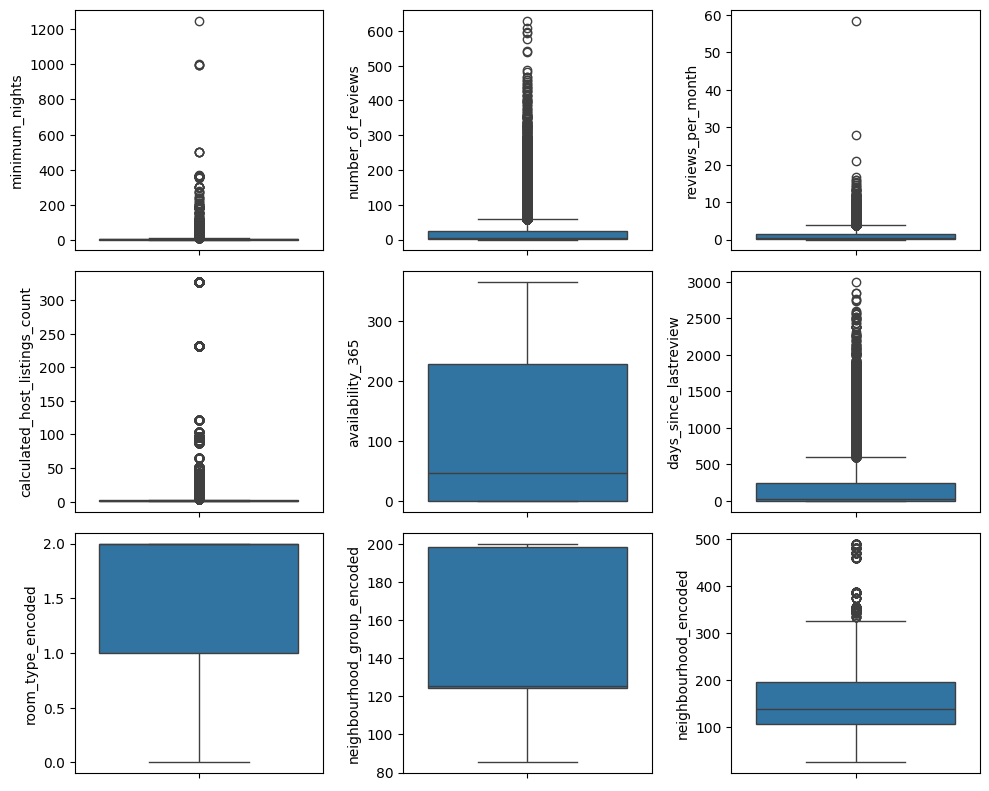

In [31]:
fig, axis = plt.subplots(3, 3, figsize = (10, 8))

sns.boxplot(ax = axis[0, 0], data = X_train, y = "minimum_nights")
sns.boxplot(ax = axis[0, 1], data = X_train, y = "number_of_reviews")
sns.boxplot(ax = axis[0, 2], data = X_train, y = "reviews_per_month")
sns.boxplot(ax = axis[1, 0], data = X_train, y = "calculated_host_listings_count")
sns.boxplot(ax = axis[1, 1], data = X_train, y = "availability_365")
sns.boxplot(ax = axis[1, 2], data = X_train, y = "days_since_lastreview")
sns.boxplot(ax = axis[2, 0], data = X_train, y = "room_type_encoded")
sns.boxplot(ax = axis[2, 1], data = X_train, y = "neighbourhood_group_encoded")
sns.boxplot(ax = axis[2, 2], data = X_train, y = "neighbourhood_encoded")

plt.tight_layout()

plt.show()

Selección de características

Método 1: Feature importance RF

In [32]:
#Entrenamiento de RFRegressor

model = RandomForestRegressor(random_state=42,n_jobs=-1).fit(X_train,y_train)

In [33]:
#Importancia caract
importances = model.feature_importances_/model.feature_importances_.sum()*100

#convertir a dataframe 
df_rf_imp = pd.DataFrame({'feature': X_train.columns,'rf_importance': importances}).sort_values(by='rf_importance',ascending=False)

#Importancia acumulada
df_rf_imp['rf_importance_acum'] = df_rf_imp['rf_importance'].cumsum()

df_rf_imp

,feature,rf_importance,rf_importance_acum
1,longitude,16.39,16.39
0,latitude,16.08,32.47
10,neighbourhood_encoded,13.69,46.16
7,days_since_lastreview,12.09,58.25
6,availability_365,9.76,68.01
2,minimum_nights,7.78,75.79
8,room_type_encoded,6.19,81.98
5,calculated_host_listings_count,5.90,87.88
4,reviews_per_month,4.95,92.83
9,neighbourhood_group_encoded,3.86,96.69


M2: Permutation/shuffle importance

In [34]:
#con conj de validación
X_train1, X_val, y_train1,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

#ajustar modelo 

model_xgb = XGBRegressor(objective='reg:squarederror',random_state = 42).fit(X_train1,y_train1)

In [35]:
#Permutaciones

perm = permutation_importance(model_xgb,X_val,y_val,n_repeats=10,random_state=42,n_jobs=-1,scoring='neg_mean_absolute_percentage_error')

In [36]:
df_perm_imp = pd.DataFrame({'feature': X_train.columns, 'perm_imp': perm.importances_mean*100}).sort_values('perm_imp', ascending=False)
df_perm_imp

,feature,perm_imp
1,longitude,46.59
10,neighbourhood_encoded,40.61
8,room_type_encoded,36.68
0,latitude,21.46
2,minimum_nights,16.63
4,reviews_per_month,15.22
5,calculated_host_listings_count,13.84
3,number_of_reviews,12.30
9,neighbourhood_group_encoded,12.24
6,availability_365,11.18


M3: SHAP

In [37]:
model_lgbm = lgb.LGBMRegressor(random_state=42, n_jobs=-1).fit(X_train1, y_train1)

explainer = shap.Explainer(model_lgbm, X_val)   
shap_vals = explainer(X_val).values

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1900
[LightGBM] [Info] Number of data points in the train set: 31292, number of used features: 11
[LightGBM] [Info] Start training from score 153.698581


 99%|===================| 7736/7824 [00:18<00:00]        

In [38]:
imp_shap = np.abs(shap_vals).mean(axis=0)
imp_shap_pct = imp_shap/imp_shap.sum()*100
df_shap_imp = pd.DataFrame({"feature": X_val.columns, "shap_imp": imp_shap_pct}).sort_values('shap_imp', ascending=False)
df_shap_imp

,feature,shap_imp
8,room_type_encoded,29.01
10,neighbourhood_encoded,15.46
6,availability_365,13.50
2,minimum_nights,11.09
3,number_of_reviews,7.59
1,longitude,6.45
0,latitude,5.32
5,calculated_host_listings_count,4.71
7,days_since_lastreview,3.55
4,reviews_per_month,2.13


Union de los 3 metodos

In [39]:
df_importances = (
    df_rf_imp
    .merge(df_perm_imp,on='feature',how='outer')
    .merge(df_shap_imp,on='feature',how='outer')
).sort_values('rf_importance',ascending=False)

df_importances

,feature,rf_importance,rf_importance_acum,perm_imp,shap_imp
4,longitude,16.39,16.39,46.59,6.45
3,latitude,16.08,32.47,21.46,5.32
6,neighbourhood_encoded,13.69,46.16,40.61,15.46
2,days_since_lastreview,12.09,58.25,7.57,3.55
0,availability_365,9.76,68.01,11.18,13.50
5,minimum_nights,7.78,75.79,16.63,11.09
10,room_type_encoded,6.19,81.98,36.68,29.01
1,calculated_host_listings_count,5.90,87.88,13.84,4.71
9,reviews_per_month,4.95,92.83,15.22,2.13
7,neighbourhood_group_encoded,3.86,96.69,12.24,1.18


In [40]:
#filtrar features con base a su importancia 

df_filt = df_importances[(df_importances['rf_importance']>=1)&(df_importances['perm_imp']>=1)&(df_importances['shap_imp']>=1)]
df_filt


,feature,rf_importance,rf_importance_acum,perm_imp,shap_imp
4,longitude,16.39,16.39,46.59,6.45
3,latitude,16.08,32.47,21.46,5.32
6,neighbourhood_encoded,13.69,46.16,40.61,15.46
2,days_since_lastreview,12.09,58.25,7.57,3.55
0,availability_365,9.76,68.01,11.18,13.50
5,minimum_nights,7.78,75.79,16.63,11.09
10,room_type_encoded,6.19,81.98,36.68,29.01
1,calculated_host_listings_count,5.90,87.88,13.84,4.71
9,reviews_per_month,4.95,92.83,15.22,2.13
7,neighbourhood_group_encoded,3.86,96.69,12.24,1.18


In [41]:
features = df_filt['feature']

features

4                          longitude
3                           latitude
6              neighbourhood_encoded
2              days_since_lastreview
0                   availability_365
5                     minimum_nights
10                 room_type_encoded
1     calculated_host_listings_count
9                  reviews_per_month
7        neighbourhood_group_encoded
8                  number_of_reviews
Name: feature, dtype: object

VIF (Variance Inflation Factor)

In [42]:

X_vif = add_constant(X_train[features]) #add_constant: intercepto

vif = pd.DataFrame([variance_inflation_factor(X_vif.values,i)for i in range(X_vif.shape[1])],index=X_vif.columns)
vif = vif.drop('const')
vif

,0
longitude,1.94
latitude,1.71
neighbourhood_encoded,2.14
days_since_lastreview,1.15
availability_365,1.19
minimum_nights,1.06
room_type_encoded,1.08
calculated_host_listings_count,1.12
reviews_per_month,1.65
neighbourhood_group_encoded,3.05


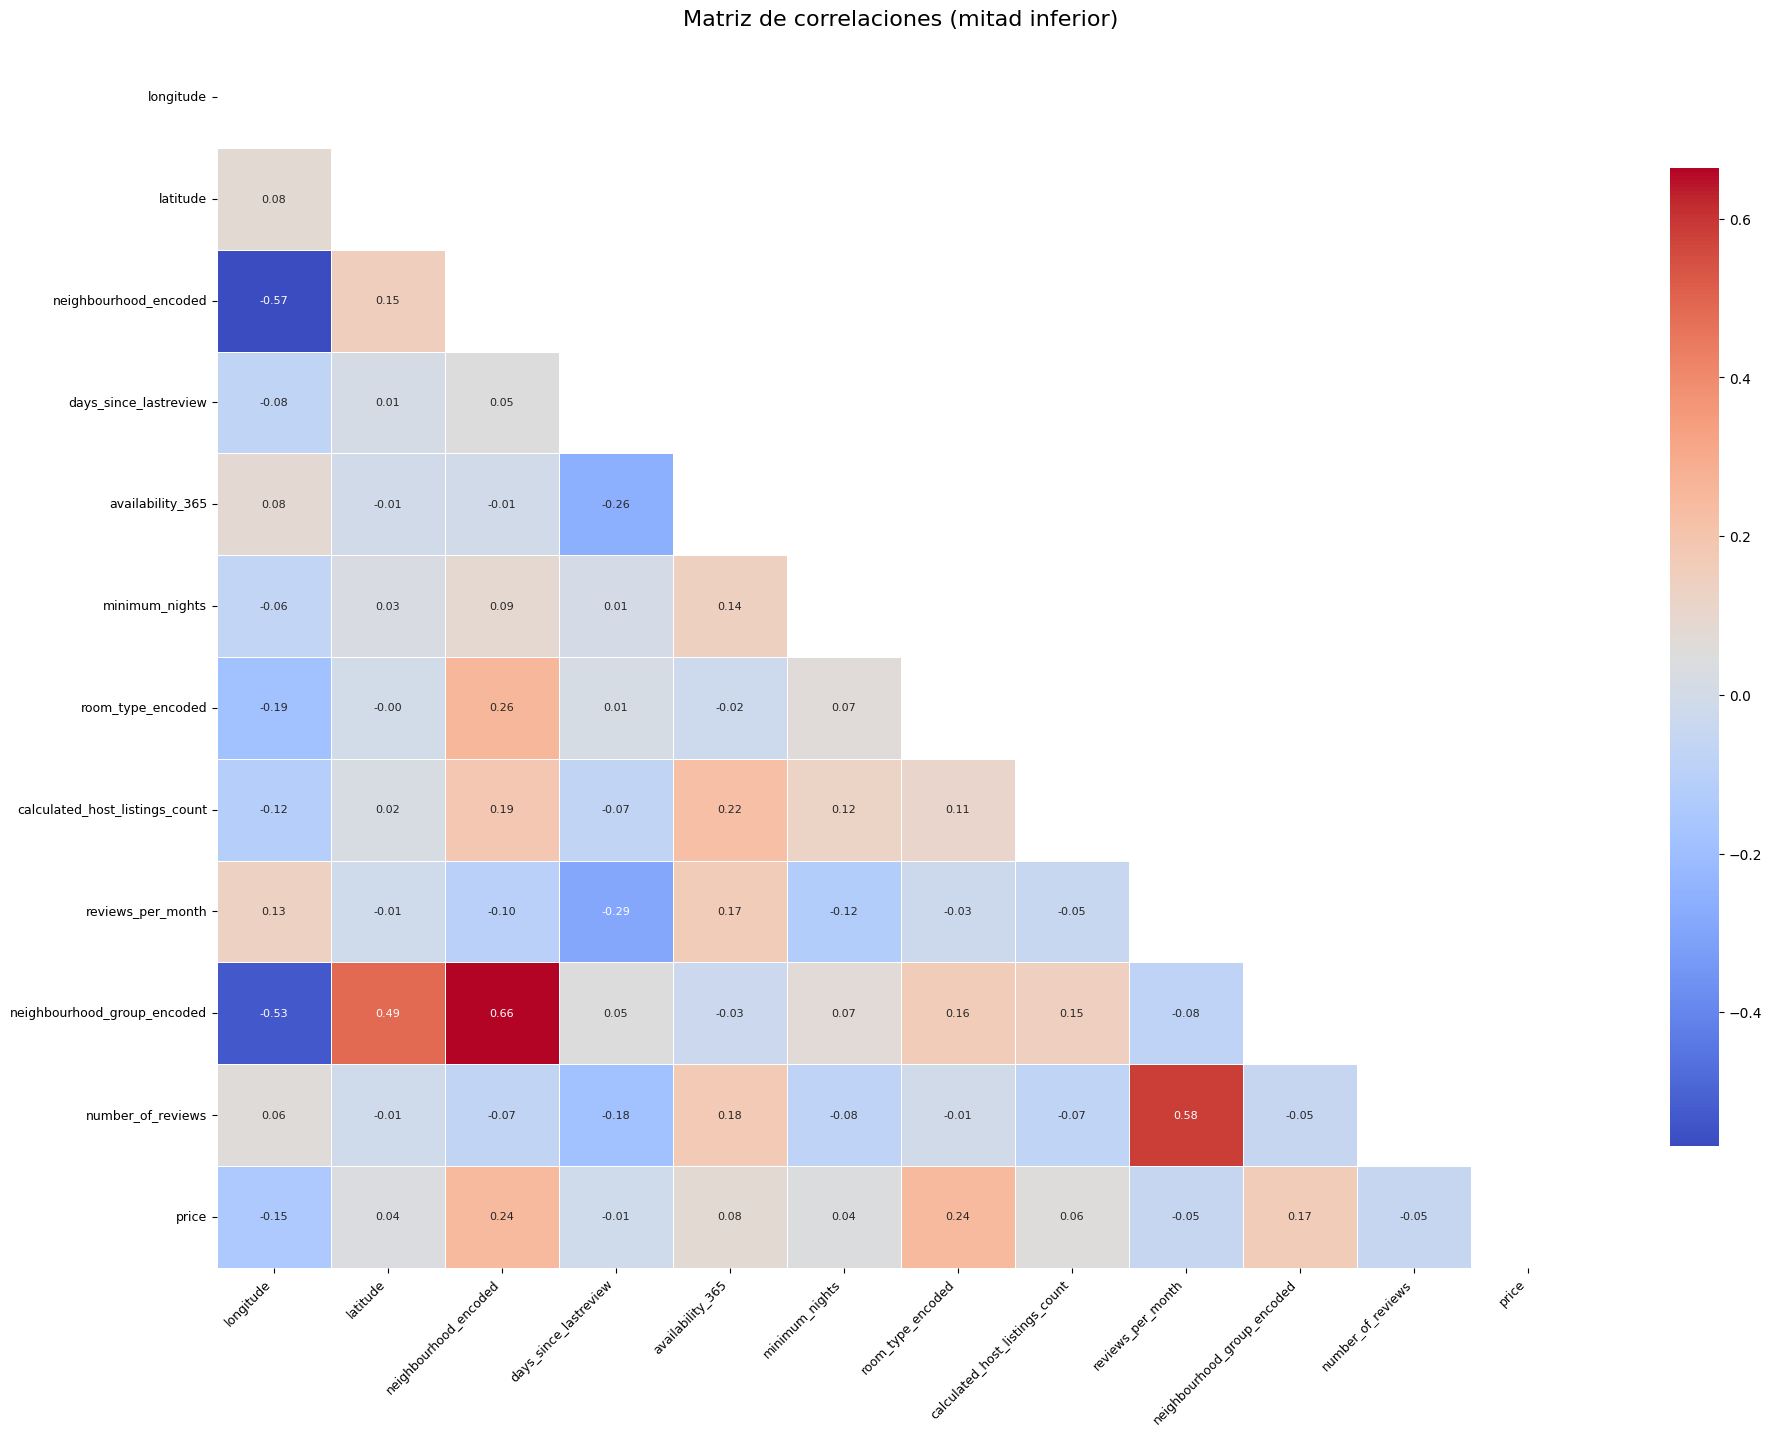

In [43]:
X_copy = X_train[features].copy()
X_copy['price'] = y_train
corr = X_copy.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(20, 15))
sns.heatmap(
    corr, mask=mask, cmap='coolwarm',
    annot=True, fmt=".2f", linewidths=.5,
    cbar_kws={"shrink": .8},
    annot_kws={"size": 8}
)
plt.title("Matriz de correlaciones (mitad inferior)", fontsize=16, pad=15)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout(pad=3.0)
plt.show()

Cross Validation

In [ ]:
#por fa obviar en la revision del EDA. 
#nota: investigar como saber que valor darle a alpha?
#v1: con todas las features candidatas

cross_val_1 = cross_val_score(Lasso(alpha=1),X_train[features],y_train,cv=3)
cross_val_1

# cross_valid_1 = cross_val_score(RandomForestRegressor(random_state=42,n_jobs=-1),X_train[features],y_train,cv=3,scoring='neg_mean_absolute_error')
# cross_valid_1

array([0.14654826, 0.10683851, 0.07520457])

In [45]:
cross_val_1.mean()

np.float64(0.10953044392441331)

In [46]:
#v2: features candidatas pero sin las correlacionadas 
#Nota: revisar scoring 
#en este caso, que me da tan similar CV1, que deberia hacer? seguir probando agregando otras variables correlacionadas? 
cross_val_2 = cross_val_score(Lasso(alpha=1),X_train[features].drop(['neighbourhood_group_encoded'],axis=1),y_train,cv=3)
cross_val_2

array([0.14687618, 0.10670153, 0.0749565 ])

In [47]:
cross_val_2.mean()

np.float64(0.10951140349326545)